In [2]:
%load_ext autoreload
%autoreload 2


import json
import os
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy

from ScheduleDistributionSampler import ScheduleDistributionSampler, activity_map, start_times, individual_histograms , KLdivergence, both_over_either


In [3]:
# kl_mat = {}
# sampler = {}
# for per in ['hard_worker','home_maker','senior','work_from_home']:
#     sampler[per] = ScheduleDistributionSampler(per)
# for per in ['hard_worker','home_maker','senior','work_from_home']:
#     kl_mat[per] = {}
#     for per2 in ['hard_worker','home_maker','senior','work_from_home']:
#         kl_mat[per][per2] = KLdivergence(sampler[per].activity_histogram, sampler[per2].activity_histogram)

# kl_mat

In [4]:
print({a : {} for a in set(activity_map.values())})

{'cleaning': {}, 'socializing': {}, 'laundry': {}, 'going_to_the_bathroom': {}, 'leave_home': {}, 'taking_medication': {}, 'playing_music': {}, 'reading': {}, 'kitchen_cleaning': {}, 'take_out_trash': {}, 'vaccuum_cleaning': {}, 'breakfast': {}, 'wash_dishes': {}, 'watching_tv': {}, 'come_home': {}, 'brushing_teeth': {}, 'showering': {}, None: {}, 'listening_to_music': {}, 'getting_dressed': {}, 'computer_work': {}, 'lunch': {}, 'dinner': {}}


In [5]:
see_activities = list(set(activity_map.values()))
see_activities.remove(None)
# individual_histograms = {}

# schedule_num = 0
# for root, dirs, files in os.walk('data/AMT_Schedules'):
#     total_files = len(files) - 4
#     fig, ind_plot = plt.subplots(total_files, len(see_activities), sharex=True, sharey=True)
#     fig.set_size_inches(80, 50)
#     scene_histogram = {}
#     for f in files:
#         if f.endswith('.json'):
#             if f in ['A3EF9IKIU8IAHY.json', 'A3FKOG3VU5MP0X.json','AFER49XXMM4PE.json','A332L3FO6RCY6G.json']:
#                 continue
#             individual_histograms[f[:-5]] = {}
#             with open(os.path.join(root,f)) as file:
#                 sch = json.load(file)
#             age = int(sch["questionnaireData"]["age"][:2])
#             if sch["questionnaireData"]["gender"] == 'Female': c = [age/60, 0, 0]
#             if sch["questionnaireData"]["gender"] == 'Male': c = [0, 0, age/60]
#             # ind_plot[schedule_num,0].set_ylabel(str(age) + ', '+gender[0])
#             activity_times = {}
#             scene_histogram[f] = {k:{s:0 for s in start_times} for k in activity_map.values()}
#             for timestring,activities in sch['activitiesChosen'].items():
#                 start_time = timestring.split('m')[0]
#                 start_time = int(start_time[:-1]) if start_time[-1] == 'a' else int(start_time[:-1])+12
#                 if start_time == 24:
#                     start_time = 12
#                 for act in activities:
#                     sch_activity = activity_map[act]
#                     scene_histogram[f][sch_activity][start_time] = 1
#             for iact,act in enumerate(see_activities):
#                 individual_histograms[f[:-5]][act] = list(scene_histogram[f][act].values())
#                 ind_plot[schedule_num][iact].bar(scene_histogram[f][act].keys(), scene_histogram[f][act].values())
#                 ind_plot[schedule_num][iact].set_yticks([])
#                 ind_plot[schedule_num][iact].set_xticks([])
#             ind_plot[schedule_num,0].set_ylabel(f[:-5], rotation=0, labelpad=100)
#             schedule_num += 1
#     print('Done')
# schedule_num -= 1
# for iact, act in enumerate(see_activities):
#     ind_plot[0,iact].set_title(act.replace('_','\n'))
#     ind_plot[schedule_num][iact].set_xticks([6,9,12,15,18,21,24])
#     ind_plot[schedule_num][iact].set_xticklabels(['6\nam','','','3\npm','','','12\nam'])

In [6]:
# with open('data/personaBasedSchedules/individual_histograms.json', 'w') as f:
#     json.dump(individual_histograms, f, indent=4)

In [7]:
# with open('data/personaBasedSchedules/corrected_histograms.json') as f:
    # corrected_histograms = json.load(f)

# fig, ind_plot = plt.subplots(len(corrected_histograms.keys()), len(see_activities), sharex=True, sharey=True)
# fig.set_size_inches(80, 50)

# for i,(id,act_hists) in enumerate(corrected_histograms.items()):
#     for j,(activity,data) in enumerate(act_hists.items()):
#         ind_plot[i][j].bar(start_times, data)
#         ind_plot[i][j].set_yticks([])
#         ind_plot[i][j].set_xticks([])
#         if i==0:
#             ind_plot[i][j].set_title(activity.replace('_','\n'))
#     ind_plot[i][0].set_ylabel(id, rotation=0, labelpad=100)

### Rule-based habits

In [8]:
persona_traits = {
'breakfast': {"has":[], "skips":[]}, 
'lunch': {"has":[], "skips":[]}, 
'dinner': {"has":[], "skips":[]}, 
'computer_work': {"less":[], "normal":[], "more":[]}, 
'going_to_the_bathroom': {"uses_bathroom":[], "does_not_use_bathroom":[]}, 
'leave_home': {"morning":[], "evening":[], "multiple_times":[], "not_at_all":[]}, 
'come_home': {"morning":[], "evening":[], "multiple_times":[], "not_at_all":[]}, 
'playing_music': {"morning":[], "evening":[], "multiple_times":[], "not_at_all":[]}, 
'getting_dressed': {"morning":[], "evening":[], "multiple_times":[], "not_at_all":[]}, 
'cleaning': {"morning":[], "evening":[], "multiple_times":[], "not_at_all":[]}, 
'socializing': {"morning":[], "evening":[], "multiple_times":[], "not_at_all":[]}, 
'listening_to_music':  {"morning":[], "evening":[], "multiple_times":[], "not_at_all":[]}, 
'taking_medication': {"morning":[], "evening":[], "multiple_times":[], "not_at_all":[]}, 
'take_out_trash': {"morning":[], "evening":[], "multiple_times":[], "not_at_all":[]}, 
'kitchen_cleaning': {"morning":[], "evening":[], "multiple_times":[], "not_at_all":[]}, 
'wash_dishes': {"morning":[], "evening":[], "multiple_times":[], "not_at_all":[]}, 
'brushing_teeth': {"morning":[], "evening":[], "multiple_times":[], "not_at_all":[]}, 
'laundry': {"morning":[], "evening":[], "multiple_times":[], "not_at_all":[]}, 
'reading': {"morning":[], "evening":[], "multiple_times":[], "not_at_all":[]}, 
'showering': {"morning":[], "evening":[], "multiple_times":[], "not_at_all":[]}, 
'vaccuum_cleaning': {"morning":[], "evening":[], "multiple_times":[], "not_at_all":[]}, 
'watching_tv': {"morning":[], "evening":[], "multiple_times":[], "not_at_all":[]}, 
}

In [9]:
# cutoff = 10
# computer_work_cutoffs = [4, 10]

# for i,(id,act_hists) in enumerate(corrected_histograms.items()):
#     for j,(activity,data) in enumerate(act_hists.items()):
#         np_data = np.array(data)
#         if set(list(persona_traits[activity].keys())) == set(["morning", "evening", "multiple_times", "not_at_all"]):
#             morning = np_data[:cutoff].sum() > 0
#             evening = np_data[cutoff:].sum() > 0
#             if morning and evening: persona_traits[activity]["multiple_times"].append(id)
#             elif morning: persona_traits[activity]["morning"].append(id)
#             elif evening: persona_traits[activity]["evening"].append(id)
#             else: persona_traits[activity]["not_at_all"].append(id)
#         if set(list(persona_traits[activity].keys())) == set(["has", "skips"]):
#             if (np_data.sum() > 0): persona_traits[activity]["has"].append(id)
#             else: persona_traits[activity]["skips"].append(id)
#         if activity == "computer_work":
#             if (np_data.sum() <= computer_work_cutoffs[0]): persona_traits[activity]["less"].append(id)
#             elif (np_data.sum() <= computer_work_cutoffs[1]): persona_traits[activity]["normal"].append(id)
#             else: persona_traits[activity]["more"].append(id)
#         if activity == "going_to_the_bathroom":
#             if (np_data.sum() > 0): persona_traits[activity]["uses_bathroom"].append(id)
#             else: persona_traits[activity]["does_not_use_bathroom"].append(id)

# persona_traits

In [10]:
# with open('data/personaBasedSchedules/persona_traits.json', 'w') as f:
#     json.dump(persona_traits, f, indent=4)

# persona_trait_frequencies = {act:{trait: len(files) for trait, files in trait_files.items()} for act,trait_files in persona_traits.items()}
# persona_trait_frequencies

In [11]:
# with open('data/personaBasedSchedules/persona_traits.json') as f:
#     persona_traits = json.load(f)

def plot_together(list_of_freqs, ax):
    for i,freqs in enumerate(list_of_freqs):
        freq_exist = np.array(start_times)[np.array(freqs) == 1]
        ax.plot(freq_exist,freq_exist*0 + i, '.')
        if sum(freqs) == 0:
            ax.plot(np.array(start_times),np.array(start_times)*0 + i, linewidth = 0.3, color=[0.8,0.8,0.8])


# trait_histograms = {}
# trait_probabilities = {}

# for activity in persona_traits:
#     trait_histograms[activity] = {}
#     trait_probabilities[activity] = {}
#     fig, axs = plt.subplots(2, len(persona_traits[activity]), sharex=True)
#     fig.set_size_inches(20, 5)
#     fig.suptitle(activity)
#     for i, (trait, files) in enumerate(persona_traits[activity].items()):
#         if len(files) == 0:
#             continue
#         trait_histograms[activity][trait] = list((np.array([np.array(corrected_histograms[f][activity]) for f in files])).mean(0))
#         trait_probabilities[activity][trait] = len(files)/total_files
#         axs[1][i].plot(start_times, trait_histograms[activity][trait], '-.k')
#         plot_together([corrected_histograms[f][activity] for f in files], axs[0][i])
#         axs[0][i].set_title('{}; p={:.2f}'.format(trait, trait_probabilities[activity][trait]))
#     fig.tight_layout()
#     plt.savefig('data/personaBasedSchedules/histograms/'+activity+'.jpg')


# with open('data/personaBasedSchedules/trait_histograms.json','w') as f:
#     json.dump(trait_histograms, f, indent=4)

In [12]:
# from copy import deepcopy
# samples = {1:[]}
# for activity, activity_traits in trait_probabilities.items():
#     prev_samples = deepcopy(samples)
#     samples = {}
#     for trait, prob in activity_traits.items():
#         for sample_prob, trait_list in prev_samples.items():
#             if sample_prob*prob > 0.00000000001:
#                 samples[sample_prob*prob] = trait_list + [(activity, trait)]
        

In [13]:
# from matplotlib import pyplot as plt
# probs = sorted(list(samples.keys()))[::-1]
# plt.plot(probs)
# # plt.xlim([0,20000])

### Clustering individuals

In [14]:
from ScheduleDistributionSampler import ScheduleDistributionSampler, activity_map, start_times, KLdivergence, individual_histograms
individual_histograms.keys()

dict_keys(['A22HIX1M4QXZBB', 'ACXP8KHFX06KR', 'A1FVXS8IM5QYO8', 'A1KYKDX6XH90OT', 'A34SIGOLUGKIHJ', 'A2146E0NJ4893F', 'APHOTULGVIEVH', 'A23KAJRDVCVGOE', 'A2K1QVO3F9M9Z9', 'A15VCKELIEEPJN', 'AM4CVEUB9KITP', 'A2P65VCJIAZOYW', 'A1MS6RMVVATCNE', 'A26M997VYVK0E6', 'A33L61XKPX76DB', 'A2E3V6BKN6ZRFX', 'AQ5KOKZQSZU0B', 'A8UJNIY9R8S7W', 'A3GWCILDIQLY6U', 'A1SH1K3O9YE16Y', 'A12VQHPT0YHMIS'])

In [15]:
activities = persona_traits.keys()
activities

dict_keys(['breakfast', 'lunch', 'dinner', 'computer_work', 'going_to_the_bathroom', 'leave_home', 'come_home', 'playing_music', 'getting_dressed', 'cleaning', 'socializing', 'listening_to_music', 'taking_medication', 'take_out_trash', 'kitchen_cleaning', 'wash_dishes', 'brushing_teeth', 'laundry', 'reading', 'showering', 'vaccuum_cleaning', 'watching_tv'])

In [22]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score

individual_features = {}
activities = persona_traits.keys()

morning = np.array([1 if i<12 else 0 for i in range(6,24)])
afternoon = np.array([1 if i>=12 and i<18 else 0 for i in range(6,24)])
evening = np.array([1 if i>=18 else 0 for i in range(6,24)])

for indiv, act_hist in individual_histograms.items():
    feat = []
    for act in ['cleaning']:
        seq = np.argwhere(act_hist[act]).reshape(-1)
        if len(seq) > 1:
            gm = GaussianMixture(n_components=2).fit(seq.reshape(-1,1))
            gm_means = gm.means_.reshape(-1)
            gm_covs = gm.covariances_.reshape(-1)
            gm_inds = gm_means.argsort()[::-1]
            gm_means = deepcopy(gm_means[gm_inds]).reshape(-1)
            gm_mean_diff = gm_means[0] - gm_means[1]
            gm_covs = deepcopy(gm_covs[gm_inds]).reshape(-1)
            median_time = np.median(seq)
        elif len(seq) == 1:
            gm_means = np.ones((2,)) * -1
            gm_means[0] = deepcopy(seq[0])
            gm_means[1] = deepcopy(seq[0])
            gm_mean_diff = 0
            gm_covs = np.zeros_like(gm_means)
            median_time = np.median(seq) if len(seq) > 0 else -1
        else:
            gm_means = np.ones((2,)) * -1
            gm_covs = np.ones((2,)) * -1
            gm_mean_diff = -1
            median_time = -1
        this_act = np.array(act_hist[act])
        feat += [sum(morning*this_act), sum(afternoon*this_act), sum(evening*this_act)]
        feat += list(gm_means)
        # feat += [gm_means[0]/18]
        feat += [gm_mean_diff]
        # feat += list(gm_covs)
        feat += [float(sum(act_hist[act]))]
    individual_features[indiv] = np.array(feat)

In [23]:
import sklearn
individual_features_array = np.array(np.array(list(individual_features.values())))
individual_features_array.shape
pca = sklearn.decomposition.PCA().fit(individual_features_array)

In [18]:
! rm -r cluster_visuals
! mkdir cluster_visuals

In [19]:
# metrics = []

(21, 7)
##### Number of clusters 2 #####  : center-to-center 14.882616835916666 : sample_to_center 3.7658736081935467
9 : 12 : 
(21, 7)
##### Number of clusters 3 #####  : center-to-center 15.671930770348796 : sample_to_center 1.9071012973707608
6 : 12 : 3 : 
(21, 7)
##### Number of clusters 4 #####  : center-to-center 13.640583165359592 : sample_to_center 1.0852421045023068
3 : 8 : 6 : 4 : 
(21, 7)
##### Number of clusters 5 #####  : center-to-center 12.40052786034216 : sample_to_center 0.767896871812082
5 : 8 : 3 : 1 : 4 : 
(21, 7)
##### Number of clusters 6 #####  : center-to-center 12.35428835055953 : sample_to_center 0.5521415418013303
5 : 8 : 2 : 1 : 4 : 1 : 
(21, 7)
##### Number of clusters 7 #####  : center-to-center 11.99717739362972 : sample_to_center 0.32266211459395
2 : 8 : 2 : 1 : 4 : 1 : 3 : 
(21, 7)
##### Number of clusters 8 #####  : center-to-center 12.24489791041825 : sample_to_center 0.16835876545333964
2 : 8 : 1 : 4 : 1 : 1 : 1 : 3 : 
(21, 7)
##### Number of cluster

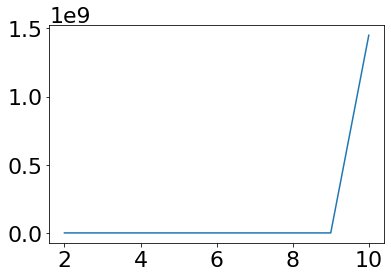

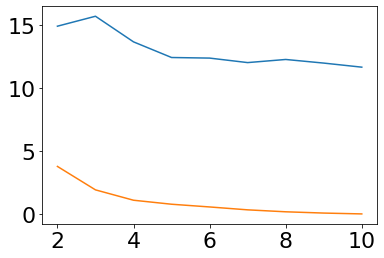

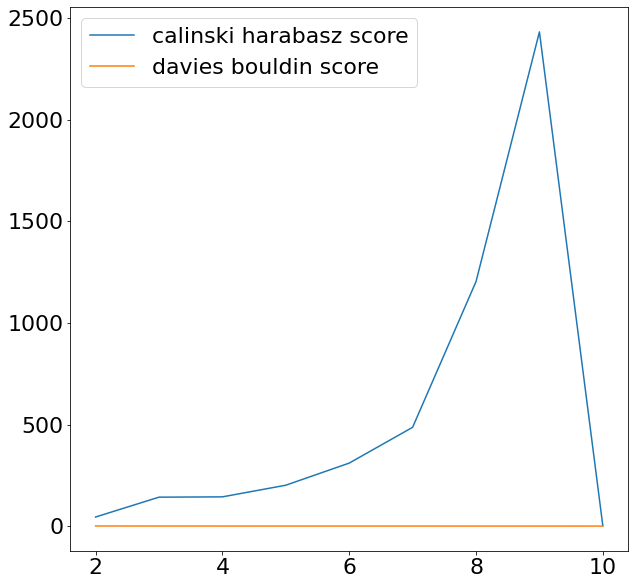

In [24]:
from ScheduleDistributionSampler import ScheduleDistributionSampler
import shutil

typename = 'new'

goodness = []
c2c = []
s2c = []
ch_score = []
db_score = []
sh_score = []

cluster_lengths = [2,3,4,5,6,7,8,9,10]
all_clusters = {k:None for k in cluster_lengths}

for n_clusters in cluster_lengths:
    individual_names = list(individual_features.keys())
    individual_features_array = np.array(np.array(list(individual_features.values())))
    print(individual_features_array.shape)
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(individual_features_array)
    cluster_center_distances = []
    for c1 in kmeans.cluster_centers_:
        for c2 in kmeans.cluster_centers_:
            cluster_center_distances.append(np.linalg.norm(c1-c2))
    avg_center_dist = sum(cluster_center_distances)/(n_clusters * (n_clusters-1))
    sample_to_center_dist = kmeans.transform(individual_features_array).min(axis=-1)
    print(f'##### Number of clusters {n_clusters} #####  : center-to-center {avg_center_dist} : sample_to_center {sample_to_center_dist.mean()}')

    goodness.append(avg_center_dist/sample_to_center_dist.mean())
    c2c.append(avg_center_dist)
    s2c.append(sample_to_center_dist.mean())
    ch_score.append(calinski_harabasz_score(individual_features_array, kmeans.labels_))
    db_score.append(davies_bouldin_score(individual_features_array, kmeans.labels_))
    sh_score.append(silhouette_score(individual_features_array, kmeans.labels_))

    clusters = []
    for n in range(n_clusters):
        print(individual_features_array[kmeans.labels_==n].shape[0], end = ' : ')
        clusters.append([name for i,name in enumerate(individual_names) if kmeans.labels_[i]==n])
        # print(clusters[-1])
    
    all_clusters[n_clusters] = clusters
    print()
    
import matplotlib.pyplot as plt
plt.plot(cluster_lengths, goodness)
fig,ax = plt.subplots()
plt.plot(cluster_lengths, c2c)
plt.plot(cluster_lengths, s2c)
fig,ax = plt.subplots()
fig.set_size_inches(10,10)
plt.plot(cluster_lengths, ch_score, label='calinski harabasz score')
plt.plot(cluster_lengths, db_score, label='davies bouldin score')
# plt.plot(cluster_lengths, sh_score, label='silhouette score')
ax.legend()
fig.savefig('cluster_visuals/scores.jpg')

In [25]:
n_clusters = 4
clusters = all_clusters[n_clusters]
cluster_histograms = [{} for _ in range(n_clusters)]

TypeError: unhashable type: 'dict'

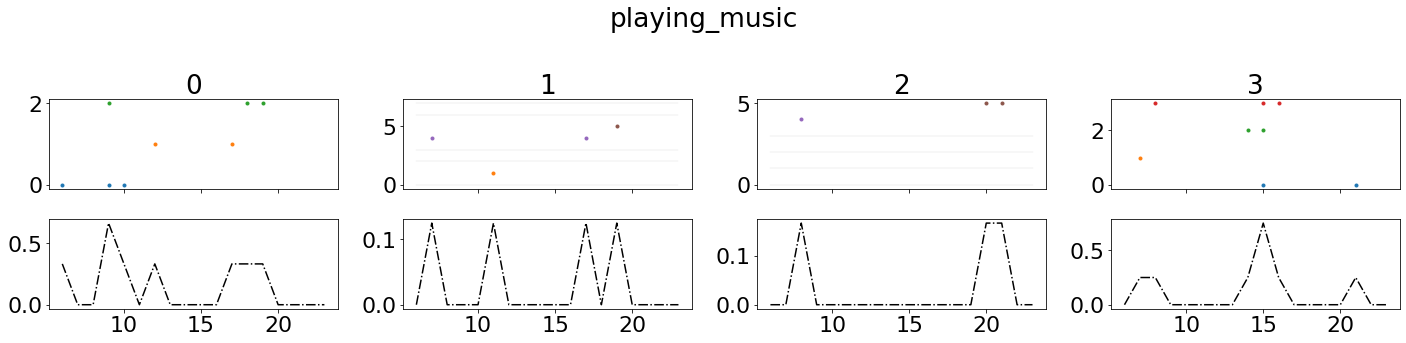

In [26]:
typename = 'scored'
root = 'cluster_visuals/'+str(n_clusters)+typename
if os.path.exists(f'{root}'):
    shutil.rmtree(f'{root}')
os.makedirs(f'{root}/histograms')

for activity in ['playing_music']:
    fig, axs = plt.subplots(2, n_clusters, sharex=True)
    fig.set_size_inches(20, 5)
    fig.suptitle(activity)
    for i, cluster in enumerate(clusters):
        avg = np.array([individual_histograms[ind][activity] for ind in cluster]).mean(axis=0)
        cluster_histograms[i][activity] = avg
        axs[1][i].plot(start_times, avg, '-.k')
        plot_together([individual_histograms[ind][activity] for ind in cluster], axs[0][i])
        # axs[0][i].set_title('{} : {}'.format(i, cluster))
        axs[0][i].set_title('{}'.format(i))
    fig.tight_layout()
    fig.savefig(f'{root}/histograms/{activity}.jpg')



for i in range(n_clusters):
    sampler = ScheduleDistributionSampler(cluster_histograms[i], custom_label='cluster : '+str(len(clusters[i])))
    dir = os.makedirs(f'{root}/{i}')
    sampler.plot(dirname=f'{root}/{i}')
    # shutil.move(f'{root}/{i}/sampling_distribution_separated.jpeg', f'{root}/{i}.jpeg')
    # shutil.rmtree(f'{root}/{i}')

kl_mat = np.zeros((n_clusters, n_clusters))
# boe_mat = np.zeros((n_clusters, n_clusters))
for i in range(n_clusters):
    for j in range(n_clusters):
        kl_mat[i][j] = KLdivergence(cluster_histograms[i], cluster_histograms[j])
        # boe_mat[i][j] = both_over_either(cluster_histograms[i], cluster_histograms[j])
avg_kl = kl_mat.sum()/(n_clusters*(n_clusters-1))
# avg_boe = boe_mat.sum()/(n_clusters*(n_clusters-1))

np.savetxt(f'{root}/boe.txt', kl_mat)
with open(f'{root}/boe.txt', 'a') as f:
    f.write('\n\n'+str(avg_kl))

# np.savetxt(f'{root}/boe.txt', boe_mat)
# with open(f'{root}/boe.txt', 'a') as f:
#     f.write('\n\n'+str(avg_boe))

with open(f'{root}/clusters.json', 'w') as f:
    json.dump(clusters, f, indent=4)

In [25]:
cluster_histograms_writable = [{k:list(v) for k,v in ch.items()} for ch in cluster_histograms]

In [27]:
with open('data/personaBasedSchedules/cluster_histograms.json','w') as f:
    json.dump(cluster_histograms_writable, f)